# Environments
## Simple Room
We start from the simple room, no obstacles and fully observable. Agent's target are the stairs, but it will get a reward for eating apples.

In [3]:
from simulator import *
from utils import *

simple_room = """
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
"""


def simple_room_generator(seed):
    game_map = make_map(simple_room, 5, premapped=True, start=(0, 0), seed=seed)
    return create_env(game_map, apple_reward=0.75, penalty_time=-0.1)


simple_room_env = simple_room_generator(seed=0)
simple_room_env.reset()
simple_room_env.render()


Hello Agent, welcome to NetHack!  You are a neutral human Caveman.              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                               -----------------                                
                               |@..............|                                
                               |...............|                                
                               |...............|                                
                               |...............|                                
                           

## Lava Room Environment
We then move to the lava room, where the agent has to avoid lava tiles while trying to reach the stairs and collect apples.
This is a more complex environment, where the agent has to account for obstacles on its way.
For this environment, we also use a bfs-based distance since the manhattan distance can't account for the lava tiles.

In [4]:
lava_maze = """
-----------------
|..L....L....L..|
|..L..LLL..L.LL.|
|..L..L.......L.|
|.....L.....L...|
|..L....L....L..|
|..LLL..L.LL.L..|
|..L.L..L..L....|
|..L....L....L..|
|.....L.....L...|
-----------------
"""


def lava_env_generator(seed):
    game_map = make_map(lava_maze, 5, premapped=True, start=(1, 1), seed=seed)
    return create_env(game_map, apple_reward=0.75, penalty_time=-0.1)


lava_room_env = lava_env_generator(seed=0)
lava_room_env.reset()
lava_room_env.render()



Hello Agent, welcome to NetHack!  You are a neutral human Caveman.              
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                              -----------------                                 
                              |@.}....}....}..|                                 
                              |..}..}}}..}.}}.|                                 
                              |..}..}.......}.|                                 
                              |.....}.....}...|                                 
                              |%.}%...}...%}..|                                 
                           

In [5]:
base_save_dir = "results/benchmarking/"

# Benchmarking Offline Pathfinding Algorithms
## A* Star-based Algorithms
We tried two approaches based on A* Star algorithm:
* Forcing the agent to path from apple to apple, using the A* Star algorithm, then to the stairs.
    * This is a greedy approach, where the agent will always try to reach the nearest apple first until all apples are collected.
* Finding a path to the stairs, but with a Weighted A* Star algorithm modified to gives more weight to tiles with/near apples.
    * This is a more exploratory approach, where the agent will try to find a path to the stairs, but will also try to collect apples along the way without being greedy.
    * Uses two parameters: `weight` and `apple_bonus`. The `weight` is the weight of the heuristic, while the `apple_bonus` is the bonus given to tiles with/near apples.

### Simple Room Environment

In [6]:
from algorithms import a_star_apple, manhattan_distance, cached_bfs, a_star_collect_apples
import numpy as np

seeds = [0, 101, 202, 303, 404, 505, 606, 707, 808, 909]


In [5]:
param_grid = {
    'weight': np.linspace(0.2, 2, 5),
    'apple_bonus': np.linspace(0.5, 5, 5)
}

a_star_apple_df = benchmark_simulation(lava_env_generator, a_star_apple, seeds, param_grid,
                                       heuristic=manhattan_distance)

Benchmarking: 100%|██████████| 250/250 [01:33<00:00,  2.67it/s]


In [6]:
a_star_apple_avg_df = a_star_apple_df.groupby(['weight', 'apple_bonus']).agg(
    avg_reward=('reward', 'mean'),
    avg_path_length=('path_length', 'mean'),
    avg_apples=('apples_eaten', 'mean'),
    success_rate=('success', 'mean'),
    avg_planning_time=('planning_time', 'mean')
).reset_index()

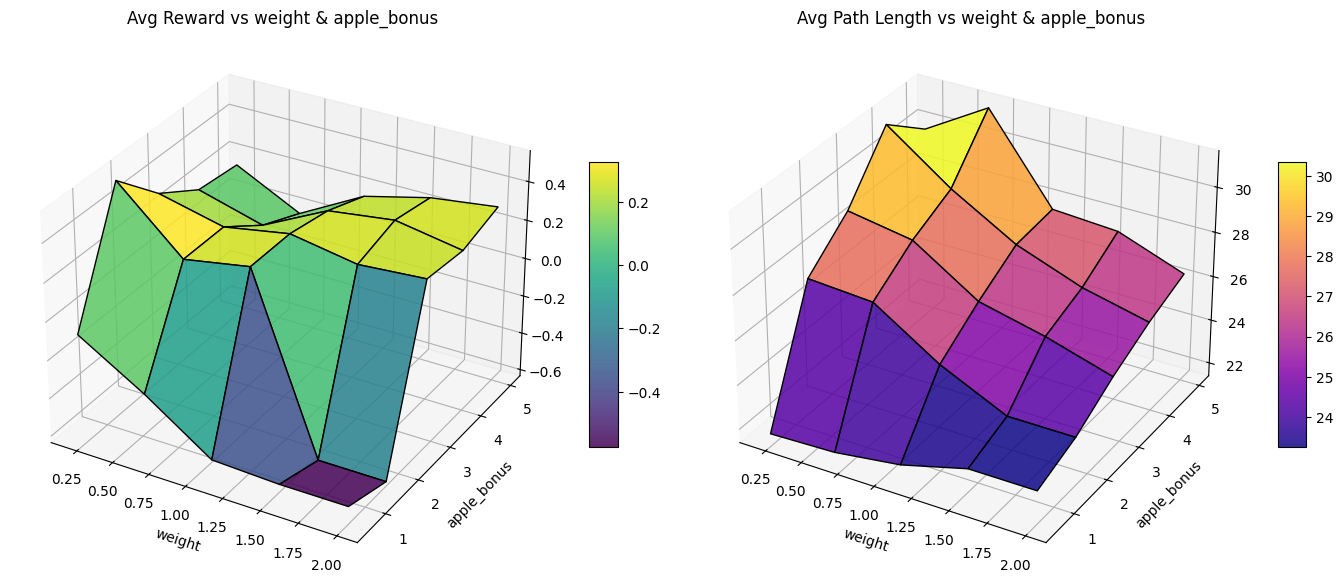

In [7]:
plot_3d_surfaces(agg_df=a_star_apple_avg_df,
                 x_col='weight',
                 y_col='apple_bonus',
                 z1_col='avg_reward',
                 z2_col='avg_path_length',
                 z1_label='Avg Reward',
                 z2_label='Avg Path Length')

In [8]:
param_grid = {
    'weight': np.linspace(0.2, 2, 5)
}

# the greedy approach doesn't need parameters, so we can just run it over multiple seeds
greedy_a_star_df = benchmark_simulation(lava_env_generator, a_star_collect_apples, seeds, param_grid)

Benchmarking: 100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


In [9]:
greedy_a_star_avg_df = greedy_a_star_df.groupby(['weight']).agg(
    avg_reward=('reward', 'mean'),
    avg_path_length=('path_length', 'mean'),
    avg_apples=('apples_eaten', 'mean'),
    success_rate=('success', 'mean'),
    avg_planning_time=('planning_time', 'mean')
).reset_index()
greedy_a_star_avg_df

,weight,avg_reward,avg_path_length,avg_apples,success_rate,avg_planning_time
0,0.20,0.880,34.7,5.0,1.0,0.061927
1,0.65,0.880,34.7,5.0,1.0,0.022068
2,1.10,1.065,34.7,5.0,1.0,0.006805
3,1.55,0.740,36.1,5.0,1.0,0.003716
4,2.00,0.740,36.1,5.0,1.0,0.002888


## Monte Carlo Tree Search (MCTS)

Without relying on heuristic, we can use MCTS to explore the environment and find a path to the stairs while collecting apples. The MCTS will simulate multiple paths and choose the one that maximizes the reward.

The MCTS has two parameters:
* `iterations`: The number of simulations to run for each node.
* `C`: The exploration constant used in the UCT formula to balance exploration and exploitation.

In [5]:
from MCTS import mcts

param_grid = {
    'C': [1.0, 1.5, 2.0, 3.0, 4.0, 5.0]  # exploration constant
}
mcts_df = benchmark_simulation(lava_env_generator, mcts, seeds, param_grid,
                               iterations=10000)

Benchmarking:   0%|          | 0/60 [00:00<?, ?it/s]

Stairs were not reached.


Benchmarking:  10%|█         | 6/60 [00:14<02:17,  2.55s/it]

Stairs were not reached.


Benchmarking:  30%|███       | 18/60 [00:44<01:44,  2.48s/it]

Stairs were not reached.


Benchmarking:  50%|█████     | 30/60 [01:23<01:28,  2.96s/it]

Stairs were not reached.


Benchmarking:  60%|██████    | 36/60 [01:39<01:05,  2.71s/it]

Stairs were not reached.


Benchmarking:  70%|███████   | 42/60 [01:54<00:48,  2.70s/it]

Stairs were not reached.


Benchmarking:  72%|███████▏  | 43/60 [01:56<00:45,  2.69s/it]

Stairs were not reached.


Benchmarking:  90%|█████████ | 54/60 [02:25<00:15,  2.52s/it]

Stairs were not reached.


Benchmarking: 100%|██████████| 60/60 [02:41<00:00,  2.69s/it]


In [6]:
mcts_avg_df = mcts_df.groupby(['C']).agg(
    avg_reward=('reward', 'mean'),
    avg_path_length=('path_length', 'mean'),
    avg_apples=('apples_eaten', 'mean'),
    success_rate=('success', 'mean'),
    avg_planning_time=('planning_time', 'mean')
).reset_index()
mcts_avg_df

,C,avg_reward,avg_path_length,avg_apples,success_rate,avg_planning_time
0,1.0,0.330,16.5,2.0,0.3,2.418097
1,1.5,0.030,27.9,2.8,0.9,2.472654
2,2.0,0.715,27.4,3.1,1.0,2.339460
3,3.0,0.475,26.4,3.1,1.0,2.353465
4,4.0,0.365,26.2,2.9,1.0,2.225223
5,5.0,0.460,24.6,2.8,1.0,2.160244


## Greedy Best First Search

The classical Greedy Best First Search algorithm uses a heuristic to find the best path to the goal. It expands the node that is closest to the goal according to the heuristic, without considering the cost of the path. No parameter to test, but we can compare different heuristics.



In [7]:
from algorithms import greedy_best_first_search

In [8]:
param_grid = {
    'heuristic': [cached_bfs, manhattan_distance]
}
greedy_df = benchmark_simulation(lava_env_generator, greedy_best_first_search, seeds, param_grid)

Benchmarking: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


In [11]:
greedy_df['heuristic'] = greedy_df['heuristic'].apply(lambda x: x.__name__ if hasattr(x, '__name__') else str(x))
greedy_avg_df = greedy_df.groupby(['heuristic']).agg(
    avg_reward=('reward', 'mean'),
    avg_path_length=('path_length', 'mean'),
    avg_apples=('apples_eaten', 'mean'),
    success_rate=('success', 'mean'),
    avg_planning_time=('planning_time', 'mean')
).reset_index()
greedy_avg_df

,heuristic,avg_reward,avg_path_length,avg_apples,success_rate,avg_planning_time
0,cached_bfs,0.85,35.0,5.0,1.0,0.054187
1,manhattan_distance,0.54,38.1,5.0,1.0,0.001745


## Potential Fields
Mostly used in robotics, potential fields can be used to guide the agent towards a goal.
The agent will be attracted to the goal (stairs and apples) based on distance, while being repelled by tiles already visited.

In [10]:
from algorithms import potential_field_path

In [11]:
param_grid = {
    'modality_potential': ['max', 'sum'],
    'weight_apple': np.linspace(0.05, 0.1, 5)
}
potential_field_df = benchmark_simulation(lava_env_generator, potential_field_path, seeds, param_grid,
                                          heuristic=cached_bfs, max_steps=500)


Benchmarking: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


In [12]:
potential_field_avg_df = potential_field_df.groupby(['modality_potential', 'weight_apple']).agg(
    avg_reward=('reward', 'mean'),
    avg_path_length=('path_length', 'mean'),
    avg_apples=('apples_eaten', 'mean'),
    success_rate=('success', 'mean'),
    avg_planning_time=('planning_time', 'mean')
).reset_index()
potential_field_avg_df

,modality_potential,weight_apple,avg_reward,avg_path_length,avg_apples,success_rate,avg_planning_time
0,max,0.0500,-0.145,43.0,4.7,1.0,0.039553
1,max,0.0625,-0.605,47.6,4.7,1.0,0.039250
2,max,0.0750,-0.605,47.6,4.7,1.0,0.039281
3,max,0.0875,-0.770,47.6,4.7,1.0,0.041068
4,max,0.1000,-0.605,47.6,4.7,1.0,0.039298
5,sum,0.0500,-0.480,21.0,0.8,1.0,0.043247
6,sum,0.0625,-0.480,21.0,0.8,1.0,0.043710
7,sum,0.0750,-0.480,21.0,0.8,1.0,0.044165
8,sum,0.0875,-0.480,21.0,0.8,1.0,0.043356
9,sum,0.1000,-0.480,21.0,0.8,1.0,0.043450


## Beam Search

Beam search is a heuristic search algorithm that explores a graph by expanding the most promising nodes in a limited set. It is similar to breadth-first search but only keeps a limited number of the best nodes at each level.

The beam search algorithm has two parameters:
* `beam_width`: The number of nodes to keep at each level.
* `apple_reward`: The bonus given when the agent steps on a tile with an apple. This is used to prioritize tiles with apples over others.

In [7]:
from algorithms import beam_search_apple
import numpy as np

param_grid = {
    'beam_width': np.arange(4, 11),  # from 4 to 10
    'apple_reward': np.arange(3, 16)  # from 3 to 15
}

beam_search_df = benchmark_simulation(lava_env_generator, beam_search_apple, seeds, param_grid)

Benchmarking: 100%|██████████| 910/910 [04:12<00:00,  3.60it/s]


In [8]:
group_cols = ['beam_width', 'apple_reward']  # adapt to your param grid
beam_search_avg_df = beam_search_df.groupby(group_cols).agg(
    avg_reward=('reward', 'mean'),
    avg_path_length=('path_length', 'mean'),
    success_rate=('success', 'mean'),
    avg_planning_time=('planning_time', 'mean')
).reset_index()

# print the combinations with a success rate less than 1
beam_search_avg_df

,beam_width,apple_reward,avg_reward,avg_path_length,success_rate,avg_planning_time
0,4,3,-0.050,28.4,1.0,0.066719
1,4,4,-0.015,28.7,1.0,0.065085
2,4,5,0.010,29.1,1.0,0.065162
3,4,6,0.010,29.1,1.0,0.064484
4,4,7,0.010,29.1,1.0,0.065742
...,...,...,...,...,...,...
86,10,11,0.055,29.3,1.0,0.065059
87,10,12,0.010,30.4,1.0,0.065395
88,10,13,0.010,30.4,1.0,0.065264
89,10,14,0.010,30.4,1.0,0.065027


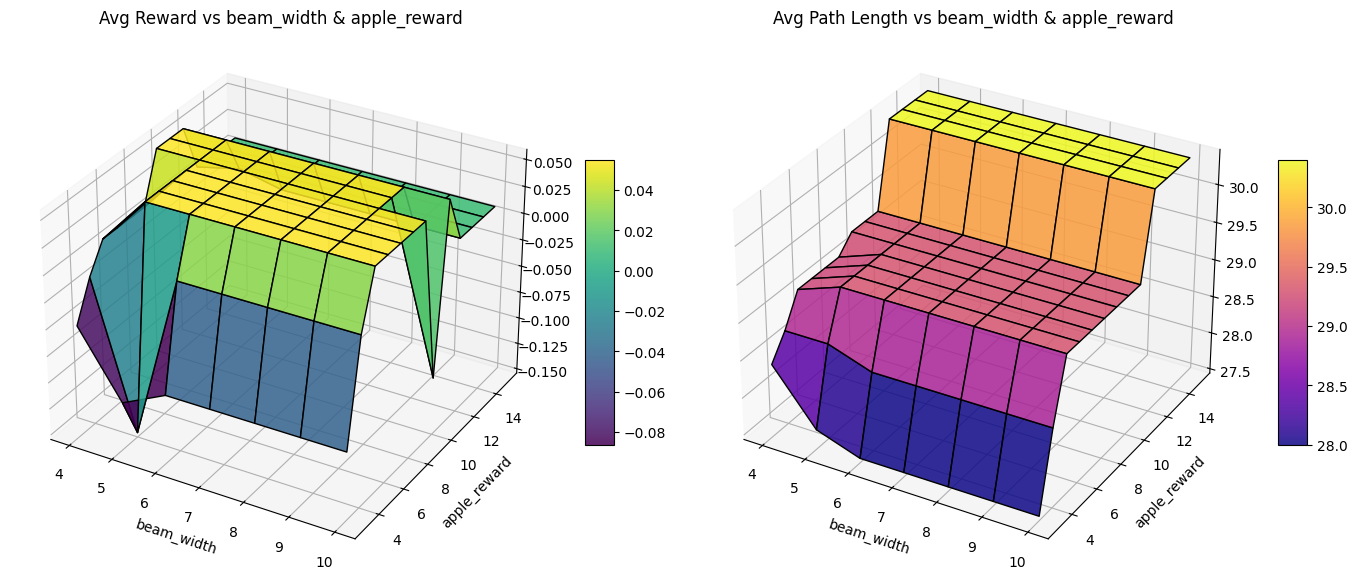

In [9]:
plot_3d_surfaces(
    agg_df=beam_search_avg_df,
    x_col='beam_width',
    y_col='apple_reward',
    z1_col='avg_reward',
    z2_col='avg_path_length',
    z1_label='Avg Reward',
    z2_label='Avg Path Length'
)
